# 1. XGBoost for Regression with Simple Data

In [2]:
import pandas as pd
import numpy as np

In [3]:
reg_data = {
    "X": [23, 24, 26, 27],
    "Y": [50, 70, 80, 85]
}
reg_data = pd.DataFrame(reg_data)
reg_data

,X,Y
0,23,50
1,24,70
2,26,80
3,27,85


In [4]:
def find_similarity_score(df, params):
    result = None
    residual_values = np.array(df["res"])
    result = (np.sum(residual_values)**2) / (len(residual_values) + params["lambda"])
    return result

def find_output_node(df, params):
    result = None
    residual_values = np.array(df["res"])
    result = np.sum(residual_values) / (len(residual_values))
    return result

def find_max_gain_node(df, params):
    gains = {}
    x = df.columns[0]
    conti_feature = np.array(df[x])
    conti_conditions = [np.mean([conti_feature[i], conti_feature[i+1]]) for i in range(len(conti_feature)-1)]
    root_sc = find_similarity_score(df, params)
    for v in conti_conditions:
        left_sc = find_similarity_score(df[df[x] < v], params)
        right_sc = find_similarity_score(df[df[x] >= v], params)
        gains[v] =  left_sc + right_sc - root_sc

    max_node = sorted(gains, key=lambda x: gains[x], reverse=True)[0]

    return max_node

def find_predicted_y(df, input, max_node, params):
    x = df.columns[0]
    predicted_y = 0
    res_value = 0
    if input >= max_node:
        res_value = find_output_node(df[df[x] >= max_node], params)
    else:
        res_value = find_output_node(df[df[x] < max_node], params)

    predicted_y = np.mean(df["Y"]) + params["lr"] * res_value

    return predicted_y

In [5]:
# Load the data
new_reg_data = reg_data.copy()

# Step 1: Build tree with parameters
reg_params = {"lambda": 0, "depth": 1, "lr": 0.3}

# Step 2: Get residuals
new_reg_data["res"] = new_reg_data["Y"] -  np.mean(new_reg_data["Y"])

# Step 3: Find node with max similarity score
reg_max_node = find_max_gain_node(new_reg_data, reg_params)

# Step 4: Find predicted y
input = 25
predicted_y = find_predicted_y(new_reg_data, input, reg_max_node, reg_params)
print(f"Output of input x = {input} is {round(predicted_y, 4)}")

Output of input x = 25 is 73.375


# 2. XGBoost for Classification with Simple Data

In [6]:
cla_data = {
    "X": [23, 24, 26, 27],
    "Y": [False, False, True, True]
}
cla_data = pd.DataFrame(cla_data)
cla_data

,X,Y
0,23,False
1,24,False
2,26,True
3,27,True


In [10]:
def find_similarity_score_cla(df, predicted_f0, params):
    result = None
    residual_values = np.array(df["res"])
    result = (np.sum(residual_values)**2) / ((predicted_f0 * (1 - predicted_f0) * len(residual_values)) + params["lambda"])
    return result

def find_output_node_cla(df, predicted_f0, params):
    result = None
    residual_values = np.array(df["res"])
    result = np.sum(residual_values) / (predicted_f0 * (1 - predicted_f0) * len(residual_values))
    return result

def find_max_gain_node_cla(df, predicted_f0, params):
    gains = {}
    x = df.columns[0]
    conti_feature = np.array(df[x])
    conti_conditions = [np.mean([conti_feature[i], conti_feature[i+1]]) for i in range(len(conti_feature)-1)]
    root_sc = find_similarity_score_cla(df, predicted_f0, params)
    for v in conti_conditions:
        left_sc = find_similarity_score_cla(df[df[x] < v], predicted_f0,  params)
        right_sc = find_similarity_score_cla(df[df[x] >= v], predicted_f0, params)
        gains[v] =  left_sc + right_sc - root_sc

    max_node = sorted(gains, key=lambda x: gains[x], reverse=True)[0]

    return max_node

def find_predicted_y_cla(df, input, max_node, predicted_f0, params):
    x = df.columns[0]
    predicted_y = 0
    res_value = 0
    if input >= max_node:
        res_value = find_output_node_cla(df[df[x] >= max_node], predicted_f0, params)
    else:
        res_value = find_output_node_cla(df[df[x] < max_node], predicted_f0, params)

    predicted_y = np.log(predicted_f0 / (1 - predicted_f0)) + params["lr"] * res_value
    predicted_y = np.exp(predicted_y) / (1 + np.exp(predicted_y))

    return predicted_y

In [12]:
# Load the data
new_cla_data = cla_data.copy()

# Step 1: Build tree with parameters
cla_params = {"lambda": 0, "depth": 1, "lr": 0.3}
predicted_f0 = 0.5

# Step 2: Get residuals
new_cla_data["y_cat"] = new_cla_data["Y"].astype(float)
new_cla_data["res"] = new_cla_data["Y"] - predicted_f0

# Step 3: Find node with max similarity score
cla_max_node = find_max_gain_node_cla(new_cla_data, predicted_f0, cla_params)

# Step 4: Find predicted y
input = 25
predicted_y = find_predicted_y_cla(new_cla_data, input, cla_max_node, predicted_f0, cla_params)
print(f"Output of input x = {input} is {round(predicted_y, 4)}")

Output of input x = 25 is 0.6457


# 3. XGBoost for Forest fire prediction

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [14]:
# Load data
dataset_path = "/content/Problem3.csv"
data_df = pd.read_csv(dataset_path)
data_df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,4.468204,26.2,94.3,1.808289,8.2,51,6.7,False,0.000000
1,7,4,oct,tue,4.517431,35.4,669.1,2.041220,18.0,33,0.9,False,0.000000
2,7,4,oct,sat,4.517431,43.7,686.9,2.041220,14.6,33,1.3,False,0.000000
3,8,6,mar,fri,4.529368,33.3,77.5,2.302585,8.3,97,4.0,True,0.000000
4,8,6,mar,sun,4.503137,51.3,102.2,2.360854,11.4,99,1.8,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,4,3,aug,sun,4.414010,56.7,665.6,1.064711,27.8,32,2.7,False,2.006871
506,2,4,aug,sun,4.414010,56.7,665.6,1.064711,21.9,71,5.8,False,4.012592
507,7,4,aug,sun,4.414010,56.7,665.6,1.064711,21.2,70,6.7,False,2.498152
508,1,4,aug,sat,4.558079,146.0,614.7,2.509599,25.6,42,4.0,False,0.000000


In [15]:
# Convert categorical data to int
categorical_cols = data_df.select_dtypes(include = ["object", "bool"]).columns.to_list()

for col_name in categorical_cols :
    n_categories = data_df[col_name].nunique()
    print(f"Number of categories in {col_name}: {n_categories}")

ordinal_encoder = OrdinalEncoder()
encoded_categorical_cols = ordinal_encoder.fit_transform(data_df[categorical_cols])

encoded_categorical_df = pd.DataFrame(encoded_categorical_cols, columns = categorical_cols)

numerical_df = data_df.drop(categorical_cols, axis = 1)
encoded_df = pd.concat([numerical_df, encoded_categorical_df ], axis = 1)

Number of categories in month: 12
Number of categories in day: 7
Number of categories in rain: 2


In [16]:
# Train, test split
X = encoded_df.drop(columns = ["area"])
y = encoded_df["area"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state = 7)

In [17]:
# Build model
xg_reg = xgb.XGBRegressor(seed = 7, learning_rate = 0.01, n_estimators = 102, max_depth = 3)
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=102, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
# Evaluation
preds = xg_reg.predict(X_test)
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)

print("Evaluation results on test set:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Evaluation results on test set:
Mean Absolute Error: 1.1484401341167767
Mean Squared Error: 1.8845074196256495


# 4. XGBoost for Wine classification

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [24]:
# Load data
dataset_path = "/content/Problem4.csv"
data_df = pd.read_csv(dataset_path)
data_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [25]:
# Train, test split
X, y = data_df.iloc[:, :-1] , data_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state = 7)

In [26]:
# Build model
xg_class = xgb.XGBClassifier(seed = 7)
xg_class.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [27]:
# Evaluation
preds = xg_class.predict(X_test)
train_acc = accuracy_score(y_train, xg_class.predict(X_train))
test_acc = accuracy_score(y_test, preds)

print(f"Train ACC: {train_acc}")
print(f"Test ACC: {test_acc}")

Train ACC: 1.0
Test ACC: 0.9629629629629629


# 5. XGBoost for Time Series Data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [34]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter = "\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

x_train, y_train = readucr("/content/FordA_TRAIN.tsv")
x_test, y_test = readucr("/content/FordA_TEST.tsv")

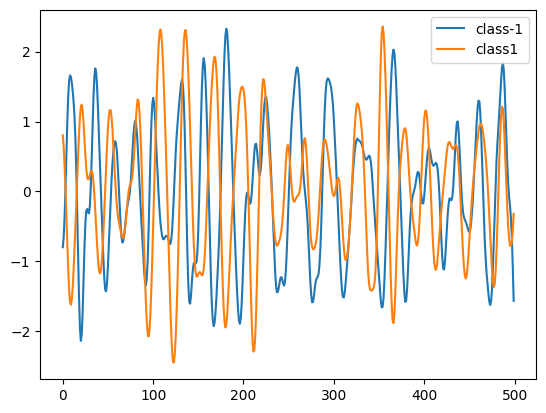

In [36]:
# Visualize data
classes = np.unique(np.concatenate((y_train, y_test), axis = 0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label = "class" + str(c))
plt.legend(loc = "best")
plt.show()
plt.close()

In [37]:
# Build model
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

model = XGBClassifier(n_estimators = 200, random_state = 42)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [39]:
# Evalution
y_pred = model.predict(x_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Confusion Matrix:
[[550 131]
 [139 500]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       681
           1       0.79      0.78      0.79       639

    accuracy                           0.80      1320
   macro avg       0.80      0.80      0.80      1320
weighted avg       0.80      0.80      0.80      1320

Accuracy: 0.80
